In [1]:
import pandas as pd

file_path = r"G:\Το Drive μου\PhD\PhdRelated\ML\WaveletAnalysis\KyotoSymhYear2015.dat"
data = pd.read_csv(file_path, sep=r'\s+', header=None, skiprows=17)
data.columns = ["Date", "Time", "DOY", "ASY-D", "ASY-H", "SYM-D", "SYM-H"]

data["Timestamp"] = pd.to_datetime(data["Date"] + " " + data["Time"])
data["DateOnly"] = data["Timestamp"].dt.date

storm_days = data[data["SYM-H"] < -100]["DateOnly"].unique()
all_days = data["DateOnly"].unique()
quiet_days = sorted(set(all_days) - set(storm_days))

print("📅 Storm Days (SYM-H < -100):", len(storm_days))
print("📅 Quiet Days:", len(quiet_days))
print("\n✅ First few storm days:", storm_days[:5])
print("✅ First few quiet days:", quiet_days[:5])


📅 Storm Days (SYM-H < -100): 12
📅 Quiet Days: 353

✅ First few storm days: [datetime.date(2015, 1, 7) datetime.date(2015, 3, 17)
 datetime.date(2015, 3, 18) datetime.date(2015, 6, 8)
 datetime.date(2015, 6, 22)]
✅ First few quiet days: [datetime.date(2015, 1, 1), datetime.date(2015, 1, 2), datetime.date(2015, 1, 3), datetime.date(2015, 1, 4), datetime.date(2015, 1, 5)]


In [2]:
# WaveletCNN.ipynb
# This notebook builds a CNN to classify spectrograms as storm/non-storm

import os
import numpy as np
import shutil
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import random

# Parameters
image_dir = r"G:\Το Drive μου\PhD\PhdRelated\ML\WaveletAnalysis\daily_spectrograms"
label_dir = r"G:\Το Drive μου\PhD\PhdRelated\ML\WaveletAnalysis\labels"
img_height, img_width = 256, 256
batch_size = 16
epochs = 10

# Step 0: Organize images based on labels
storm_file = os.path.join(label_dir, "storm_days.csv")
quiet_file = os.path.join(label_dir, "quiet_days.csv")

storm_days = pd.read_csv(storm_file, header=None)[0].tolist()
quiet_days = pd.read_csv(quiet_file, header=None)[0].tolist()

# Randomly select N quiet days to balance dataset
quiet_days = random.sample(quiet_days, min(len(storm_days), len(quiet_days)))

# Clear previous directories
storm_dir = os.path.join(image_dir, "storm")
quiet_dir = os.path.join(image_dir, "quiet")
shutil.rmtree(storm_dir, ignore_errors=True)
shutil.rmtree(quiet_dir, ignore_errors=True)
os.makedirs(storm_dir, exist_ok=True)
os.makedirs(quiet_dir, exist_ok=True)

# Copy files to respective directories
for date in storm_days:
    fname = f"spectrogram_{date}.png"
    src = os.path.join(image_dir, fname)
    dst = os.path.join(storm_dir, fname)
    if os.path.exists(src):
        shutil.copy(src, dst)

for date in quiet_days:
    fname = f"spectrogram_{date}.png"
    src = os.path.join(image_dir, fname)
    dst = os.path.join(quiet_dir, fname)
    if os.path.exists(src):
        shutil.copy(src, dst)

print(f"✅ Balanced dataset: {len(storm_days)} storm vs {len(quiet_days)} quiet")

# 1. Load images from directory
balanced_dir = image_dir  # since we now use storm/ and quiet/ folders

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    balanced_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    balanced_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

# 2. Define CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 🛑 Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# 3. Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=[early_stopping]
)

# 4. Plot training results
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.legend()

plt.tight_layout()
plt.show()

# 5. Save model
model.save("wavelet_cnn_model.h5")
print("Model saved as wavelet_cnn_model.h5")

# 6. Evaluate on validation set
val_generator.reset()
preds = model.predict(val_generator, verbose=1)
predicted_labels = (preds > 0.5).astype(int).flatten()
true_labels = val_generator.classes
filenames = val_generator.filenames

misclassified_indices = np.where(predicted_labels != true_labels)[0]
print("\n❌ Misclassified images:")
for i in misclassified_indices:
    print(f"{filenames[i]} - True: {true_labels[i]} Predicted: {predicted_labels[i]}")


✅ Balanced dataset: 6 storm vs 6 quiet
Found 0 images belonging to 2 classes.
Found 0 images belonging to 2 classes.


C:\Users\User\miniconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\User\miniconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


ValueError: The PyDataset has length 0

In [3]:
# WaveletCNN.ipynb
# This notebook builds a CNN to classify spectrograms as storm/non-storm

import os
import numpy as np
import shutil
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import random

# Parameters
image_dir = r"G:\Το Drive μου\PhD\PhdRelated\ML\WaveletAnalysis\daily_spectrograms"
label_dir = r"G:\Το Drive μου\PhD\PhdRelated\ML\WaveletAnalysis\labels"
img_height, img_width = 256, 256
batch_size = 16
epochs = 10

# Step 0: Organize images based on labels
storm_file = os.path.join(label_dir, "storm_days.csv")
quiet_file = os.path.join(label_dir, "quiet_days.csv")

storm_days = pd.read_csv(storm_file, header=None)[0].tolist()
quiet_days = pd.read_csv(quiet_file, header=None)[0].tolist()

# Randomly select N quiet days to balance dataset
quiet_days = random.sample(quiet_days, min(len(storm_days), len(quiet_days)))

# Clear previous directories
storm_dir = os.path.join(image_dir, "storm")
quiet_dir = os.path.join(image_dir, "quiet")
shutil.rmtree(storm_dir, ignore_errors=True)
shutil.rmtree(quiet_dir, ignore_errors=True)
os.makedirs(storm_dir, exist_ok=True)
os.makedirs(quiet_dir, exist_ok=True)

# Copy files to respective directories
for date in storm_days:
    fname = f"spectrogram_{date}.png"
    src = os.path.join(image_dir, fname)
    dst = os.path.join(storm_dir, fname)
    if os.path.exists(src):
        shutil.copy(src, dst)
    else:
        print(f"⚠️ Missing storm file: {src}")
      


for date in quiet_days:
    fname = f"spectrogram_{date}.png"
    src = os.path.join(image_dir, fname)
    dst = os.path.join(quiet_dir, fname)
    if os.path.exists(src):
        shutil.copy(src, dst)
    else:
        print(f"⚠️ Missing quiet file: {src}")

print(f"✅ Balanced dataset: {len(storm_days)} storm vs {len(quiet_days)} quiet")

# 1. Load images from directory
balanced_dir = image_dir  # since we now use storm/ and quiet/ folders

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    balanced_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    balanced_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

# 2. Define CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 🛑 Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# 3. Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=[early_stopping]
)

# 4. Plot training results
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.legend()

plt.tight_layout()
plt.show()

# 5. Save model
model.save("wavelet_cnn_model.h5")
print("Model saved as wavelet_cnn_model.h5")

# 6. Evaluate on validation set
val_generator.reset()
preds = model.predict(val_generator, verbose=1)
predicted_labels = (preds > 0.5).astype(int).flatten()
true_labels = val_generator.classes
filenames = val_generator.filenames

misclassified_indices = np.where(predicted_labels != true_labels)[0]
print("\n❌ Misclassified images:")
for i in misclassified_indices:
    print(f"{filenames[i]} - True: {true_labels[i]} Predicted: {predicted_labels[i]}")


⚠️ Missing storm file: G:\Το Drive μου\PhD\PhdRelated\ML\WaveletAnalysis\daily_spectrograms\spectrogram_Date.png
⚠️ Missing storm file: G:\Το Drive μου\PhD\PhdRelated\ML\WaveletAnalysis\daily_spectrograms\spectrogram_2015-03-17.png
⚠️ Missing storm file: G:\Το Drive μου\PhD\PhdRelated\ML\WaveletAnalysis\daily_spectrograms\spectrogram_2015-03-18.png
⚠️ Missing storm file: G:\Το Drive μου\PhD\PhdRelated\ML\WaveletAnalysis\daily_spectrograms\spectrogram_2015-06-23.png
⚠️ Missing storm file: G:\Το Drive μου\PhD\PhdRelated\ML\WaveletAnalysis\daily_spectrograms\spectrogram_2015-12-20.png
⚠️ Missing storm file: G:\Το Drive μου\PhD\PhdRelated\ML\WaveletAnalysis\daily_spectrograms\spectrogram_2015-12-21.png
⚠️ Missing quiet file: G:\Το Drive μου\PhD\PhdRelated\ML\WaveletAnalysis\daily_spectrograms\spectrogram_2015-04-07.png
⚠️ Missing quiet file: G:\Το Drive μου\PhD\PhdRelated\ML\WaveletAnalysis\daily_spectrograms\spectrogram_2015-11-26.png
⚠️ Missing quiet file: G:\Το Drive μου\PhD\PhdRelated\

C:\Users\User\miniconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\User\miniconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


ValueError: The PyDataset has length 0

In [4]:
# WaveletCNN.ipynb
# This notebook builds a CNN to classify spectrograms as storm/non-storm

import os
import numpy as np
import shutil
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import random

# Parameters
image_dir = r"G:\Το Drive μου\PhD\PhdRelated\ML\WaveletAnalysis\daily_spectrograms"
label_dir = r"G:\Το Drive μου\PhD\PhdRelated\ML\WaveletAnalysis\labels"
img_height, img_width = 256, 256
batch_size = 16
epochs = 10

# Step 0: Organize images based on labels
storm_file = os.path.join(label_dir, "storm_days.csv")
quiet_file = os.path.join(label_dir, "quiet_days.csv")

storm_days = pd.read_csv(storm_file, header=None)[0].tolist()
quiet_days = pd.read_csv(quiet_file, header=None)[0].tolist()

# Clean possible headers or malformed values
storm_days = [pd.to_datetime(str(d)).date() for d in storm_days if "Date" not in str(d)]
quiet_days = [pd.to_datetime(str(d)).date() for d in quiet_days if "Date" not in str(d)]

# Randomly select N quiet days to balance dataset
quiet_days = random.sample(quiet_days, min(len(storm_days), len(quiet_days)))

# Clear previous directories
storm_dir = os.path.join(image_dir, "storm")
quiet_dir = os.path.join(image_dir, "quiet")
shutil.rmtree(storm_dir, ignore_errors=True)
shutil.rmtree(quiet_dir, ignore_errors=True)
os.makedirs(storm_dir, exist_ok=True)
os.makedirs(quiet_dir, exist_ok=True)

# Copy files to respective directories
for date in storm_days:
    fname = f"spectrogram_{date}.png"
    src = os.path.join(image_dir, fname)
    dst = os.path.join(storm_dir, fname)
    if os.path.exists(src):
        shutil.copy(src, dst)
    else:
        print(f"⚠️ Missing storm file: {src}")

for date in quiet_days:
    fname = f"spectrogram_{date}.png"
    src = os.path.join(image_dir, fname)
    dst = os.path.join(quiet_dir, fname)
    if os.path.exists(src):
        shutil.copy(src, dst)
    else:
        print(f"⚠️ Missing quiet file: {src}")

print(f"✅ Balanced dataset: {len(storm_days)} storm vs {len(quiet_days)} quiet")

# 1. Load images from directory
balanced_dir = image_dir  # since we now use storm/ and quiet/ folders

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    balanced_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    balanced_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

# 2. Define CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 🛑 Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# 3. Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=[early_stopping]
)

# 4. Plot training results
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.legend()

plt.tight_layout()
plt.show()

# 5. Save model
model.save("wavelet_cnn_model.h5")
print("Model saved as wavelet_cnn_model.h5")

# 6. Evaluate on validation set
val_generator.reset()
preds = model.predict(val_generator, verbose=1)
predicted_labels = (preds > 0.5).astype(int).flatten()
true_labels = val_generator.classes
filenames = val_generator.filenames

misclassified_indices = np.where(predicted_labels != true_labels)[0]
print("\n❌ Misclassified images:")
for i in misclassified_indices:
    print(f"{filenames[i]} - True: {true_labels[i]} Predicted: {predicted_labels[i]}")


⚠️ Missing storm file: G:\Το Drive μου\PhD\PhdRelated\ML\WaveletAnalysis\daily_spectrograms\spectrogram_2015-03-17.png
⚠️ Missing storm file: G:\Το Drive μου\PhD\PhdRelated\ML\WaveletAnalysis\daily_spectrograms\spectrogram_2015-03-18.png
⚠️ Missing storm file: G:\Το Drive μου\PhD\PhdRelated\ML\WaveletAnalysis\daily_spectrograms\spectrogram_2015-06-23.png
⚠️ Missing storm file: G:\Το Drive μου\PhD\PhdRelated\ML\WaveletAnalysis\daily_spectrograms\spectrogram_2015-12-20.png
⚠️ Missing storm file: G:\Το Drive μου\PhD\PhdRelated\ML\WaveletAnalysis\daily_spectrograms\spectrogram_2015-12-21.png
⚠️ Missing quiet file: G:\Το Drive μου\PhD\PhdRelated\ML\WaveletAnalysis\daily_spectrograms\spectrogram_2015-06-03.png
⚠️ Missing quiet file: G:\Το Drive μου\PhD\PhdRelated\ML\WaveletAnalysis\daily_spectrograms\spectrogram_2015-05-16.png
⚠️ Missing quiet file: G:\Το Drive μου\PhD\PhdRelated\ML\WaveletAnalysis\daily_spectrograms\spectrogram_2015-08-30.png
⚠️ Missing quiet file: G:\Το Drive μου\PhD\PhdRe

C:\Users\User\miniconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\User\miniconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


ValueError: The PyDataset has length 0

In [5]:
# WaveletCNN.ipynb
# This notebook builds a CNN to classify spectrograms as storm/non-storm

import os
import numpy as np
import shutil
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import random

# Parameters
image_dir = r"G:\Το Drive μου\PhD\PhdRelated\ML\WaveletAnalysis\daily_spectrograms"
label_dir = r"G:\Το Drive μου\PhD\PhdRelated\ML\WaveletAnalysis\labels"
storm_dir = os.path.join(image_dir, "storm")
quiet_dir = os.path.join(image_dir, "quiet")
img_height, img_width = 256, 256
batch_size = 16
epochs = 10

# Step 0: Load date labels
storm_days = pd.read_csv(os.path.join(label_dir, "storm_days.csv"), header=None)[0].tolist()
quiet_days = pd.read_csv(os.path.join(label_dir, "quiet_days.csv"), header=None)[0].tolist()

# Clean possible headers or malformed values
storm_days = [pd.to_datetime(str(d)).date() for d in storm_days if "Date" not in str(d)]
quiet_days = [pd.to_datetime(str(d)).date() for d in quiet_days if "Date" not in str(d)]

# Randomly select N quiet days to balance dataset
quiet_days = random.sample(quiet_days, min(len(storm_days), len(quiet_days)))

# Step 1: Clear previous folders and recreate
shutil.rmtree(storm_dir, ignore_errors=True)
shutil.rmtree(quiet_dir, ignore_errors=True)
os.makedirs(storm_dir, exist_ok=True)
os.makedirs(quiet_dir, exist_ok=True)

# Step 2: Search all .png files and match them to storm or quiet sets
all_files = []
for root, _, files in os.walk(image_dir):
    for f in files:
        if f.endswith(".png") and f.startswith("spectrogram_"):
            full_path = os.path.join(root, f)
            all_files.append(full_path)

moved_storm, moved_quiet = 0, 0
for filepath in all_files:
    fname = os.path.basename(filepath)
    try:
        date_str = fname.replace("spectrogram_", "").replace(".png", "")
        file_date = pd.to_datetime(date_str).date()
    except:
        continue

    if file_date in storm_days:
        shutil.copy(filepath, os.path.join(storm_dir, fname))
        moved_storm += 1
    elif file_date in quiet_days:
        shutil.copy(filepath, os.path.join(quiet_dir, fname))
        moved_quiet += 1

print(f"✅ Copied {moved_storm} storm and {moved_quiet} quiet spectrograms")
print("\n📁 Sample files inside subfolders:")
print("📂 storm/:", os.listdir(storm_dir)[:3])
print("📂 quiet/:", os.listdir(quiet_dir)[:3])

# 3. Load images
balanced_dir = image_dir  # storm/ and quiet/ are in there

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    balanced_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    balanced_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

# 4. Define CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 🛑 Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# 5. Train
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=[early_stopping]
)

# 6. Plot results
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.legend()
plt.tight_layout()
plt.show()

# 7. Save model
model.save("wavelet_cnn_model.h5")
print("✅ Model saved as wavelet_cnn_model.h5")

# 8. Evaluate on validation set
val_generator.reset()
preds = model.predict(val_generator, verbose=1)
predicted_labels = (preds > 0.5).astype(int).flatten()
true_labels = val_generator.classes
filenames = val_generator.filenames

misclassified_indices = np.where(predicted_labels != true_labels)[0]
print("\n❌ Misclassified images:")
for i in misclassified_indices:
    print(f"{filenames[i]} - True: {true_labels[i]} Predicted: {predicted_labels[i]}")


✅ Copied 0 storm and 0 quiet spectrograms
Found 0 images belonging to 2 classes.
Found 0 images belonging to 2 classes.


C:\Users\User\miniconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\User\miniconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


ValueError: The PyDataset has length 0

In [6]:
import glob

spectros = glob.glob(r"G:\Το Drive μου\PhD\PhdRelated\ML\WaveletAnalysis\daily_spectrograms\*.png")
print(f"Total spectrograms found: {len(spectros)}")
print("First few:")
for f in spectros[:5]:
    print(os.path.basename(f))


Total spectrograms found: 221
First few:
spectrogram_2015-01-01.png
spectrogram_2015-01-02.png
spectrogram_2015-01-03.png
spectrogram_2015-01-04.png
spectrogram_2015-01-05.png


In [7]:
import pandas as pd

label_dir = r"G:\Το Drive μου\PhD\PhdRelated\ML\WaveletAnalysis\labels"
storm_days = pd.read_csv(os.path.join(label_dir, "storm_days.csv"), header=None)[0].tolist()
storm_days = [pd.to_datetime(str(d)).date() for d in storm_days if "Date" not in str(d)]

print("First few storm dates:")
print(storm_days[:5])


First few storm dates:
[datetime.date(2015, 3, 17), datetime.date(2015, 3, 18), datetime.date(2015, 6, 23), datetime.date(2015, 12, 20), datetime.date(2015, 12, 21)]


In [8]:
# WaveletCNN.ipynb
# This notebook builds a CNN to classify spectrograms as storm/non-storm

import os
import numpy as np
import shutil
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import random

# Parameters
image_dir = r"G:\Το Drive μου\PhD\PhdRelated\ML\WaveletAnalysis\daily_spectrograms"
label_dir = r"G:\Το Drive μου\PhD\PhdRelated\ML\WaveletAnalysis\labels"
storm_dir = os.path.join(image_dir, "storm")
quiet_dir = os.path.join(image_dir, "quiet")
img_height, img_width = 256, 256
batch_size = 16
epochs = 10

# Step 0: Load date labels
storm_days = pd.read_csv(os.path.join(label_dir, "storm_days.csv"), header=None)[0].tolist()
quiet_days = pd.read_csv(os.path.join(label_dir, "quiet_days.csv"), header=None)[0].tolist()

# Clean possible headers or malformed values
storm_days = [pd.to_datetime(str(d)).date() for d in storm_days if "Date" not in str(d)]
quiet_days = [pd.to_datetime(str(d)).date() for d in quiet_days if "Date" not in str(d)]

# Randomly select N quiet days to balance dataset
quiet_days = random.sample(quiet_days, min(len(storm_days), len(quiet_days)))

# Step 1: Clear previous folders and recreate
shutil.rmtree(storm_dir, ignore_errors=True)
shutil.rmtree(quiet_dir, ignore_errors=True)
os.makedirs(storm_dir, exist_ok=True)
os.makedirs(quiet_dir, exist_ok=True)

# Step 2: Search all .png files and match them to storm or quiet sets
all_files = []
for root, _, files in os.walk(image_dir):
    for f in files:
        if f.endswith(".png") and f.startswith("spectrogram_"):
            full_path = os.path.join(root, f)
            all_files.append(full_path)

moved_storm, moved_quiet = 0, 0
# Convert storm/quiet days to strings for safe comparison
storm_days_str = {d.strftime('%Y-%m-%d') for d in storm_days}
quiet_days_str = {d.strftime('%Y-%m-%d') for d in quiet_days}

moved_storm, moved_quiet = 0, 0
for filepath in all_files:
    fname = os.path.basename(filepath)
    try:
        date_str = fname.replace("spectrogram_", "").replace(".png", "")
        if date_str in storm_days_str:
            dest = os.path.join(storm_dir, fname)
            shutil.copy(filepath, dest)
            moved_storm += 1
        elif date_str in quiet_days_str:
            dest = os.path.join(quiet_dir, fname)
            shutil.copy(filepath, dest)
            moved_quiet += 1
    except Exception as e:
        print(f"⚠️ Error parsing {fname}: {e}")
        continue

print(f"✅ Copied {moved_storm} storm and {moved_quiet} quiet spectrograms")
print("\n📁 Sample files inside subfolders:")
print("📂 storm/:", os.listdir(storm_dir)[:3])
print("📂 quiet/:", os.listdir(quiet_dir)[:3])

# 3. Load images
balanced_dir = image_dir  # storm/ and quiet/ are in there

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    balanced_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    balanced_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

# 4. Define CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 🛑 Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# 5. Train
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=[early_stopping]
)

# 6. Plot results
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.legend()
plt.tight_layout()
plt.show()

# 7. Save model
model.save("wavelet_cnn_model.h5")
print("✅ Model saved as wavelet_cnn_model.h5")

# 8. Evaluate on validation set
val_generator.reset()
preds = model.predict(val_generator, verbose=1)
predicted_labels = (preds > 0.5).astype(int).flatten()
true_labels = val_generator.classes
filenames = val_generator.filenames

misclassified_indices = np.where(predicted_labels != true_labels)[0]
print("\n❌ Misclassified images:")
for i in misclassified_indices:
    print(f"{filenames[i]} - True: {true_labels[i]} Predicted: {predicted_labels[i]}")


✅ Copied 0 storm and 0 quiet spectrograms

📁 Sample files inside subfolders:
📂 storm/: []
📂 quiet/: []
Found 0 images belonging to 2 classes.
Found 0 images belonging to 2 classes.


C:\Users\User\miniconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\User\miniconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


ValueError: The PyDataset has length 0

In [9]:
# WaveletCNN.ipynb
# This notebook builds a CNN to classify spectrograms as storm/non-storm

import os
import numpy as np
import shutil
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import random

# Parameters
image_dir = r"G:\Το Drive μου\PhD\PhdRelated\ML\WaveletAnalysis\daily_spectrograms"
label_dir = r"G:\Το Drive μου\PhD\PhdRelated\ML\WaveletAnalysis\labels"
storm_dir = os.path.join(image_dir, "storm")
quiet_dir = os.path.join(image_dir, "quiet")
img_height, img_width = 256, 256
batch_size = 16
epochs = 10

# Step 0: Load date labels
storm_days = pd.read_csv(os.path.join(label_dir, "storm_days.csv"), header=None)[0].tolist()
quiet_days = pd.read_csv(os.path.join(label_dir, "quiet_days.csv"), header=None)[0].tolist()

# Clean possible headers or malformed values
storm_days = [pd.to_datetime(str(d)).date() for d in storm_days if "Date" not in str(d)]
quiet_days = [pd.to_datetime(str(d)).date() for d in quiet_days if "Date" not in str(d)]

# Randomly select N quiet days to balance dataset
quiet_days = random.sample(quiet_days, min(len(storm_days), len(quiet_days)))

# Step 1: Clear previous folders and recreate
shutil.rmtree(storm_dir, ignore_errors=True)
shutil.rmtree(quiet_dir, ignore_errors=True)
os.makedirs(storm_dir, exist_ok=True)
os.makedirs(quiet_dir, exist_ok=True)

# Step 2: Search all .png files and match them to storm or quiet sets
all_files = []
for root, _, files in os.walk(image_dir):
    for f in files:
        if f.endswith(".png") and f.startswith("spectrogram_"):
            full_path = os.path.join(root, f)
            all_files.append(full_path)

moved_storm, moved_quiet = 0, 0
# Convert storm/quiet days to strings for safe comparison
storm_days_str = {d.strftime('%Y-%m-%d') for d in storm_days}
quiet_days_str = {d.strftime('%Y-%m-%d') for d in quiet_days}

moved_storm, moved_quiet = 0, 0
for filepath in all_files:
    fname = os.path.basename(filepath)
    try:
        date_str = fname.replace("spectrogram_", "").replace(".png", "")
        if date_str in storm_days_str:
            dest = os.path.join(storm_dir, fname)
            shutil.copy(filepath, dest)
            moved_storm += 1
        elif date_str in quiet_days_str:
            dest = os.path.join(quiet_dir, fname)
            shutil.copy(filepath, dest)
            moved_quiet += 1
    except Exception as e:
        print(f"⚠️ Error parsing {fname}: {e}")
        continue

print(f"✅ Copied {moved_storm} storm and {moved_quiet} quiet spectrograms")
print("\n📁 Sample files inside subfolders:")
print("📂 storm/:", os.listdir(storm_dir)[:3])
print("📂 quiet/:", os.listdir(quiet_dir)[:3])

# 3. Load images
balanced_dir = image_dir  # storm/ and quiet/ are in there

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    balanced_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    balanced_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

# 4. Define CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 🛑 Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# 5. Train
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=[early_stopping]
)

# 6. Plot results
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.legend()
plt.tight_layout()
plt.show()

# 7. Save model
model.save("wavelet_cnn_model.h5")
print("✅ Model saved as wavelet_cnn_model.h5")

# 8. Evaluate on validation set
val_generator.reset()
preds = model.predict(val_generator, verbose=1)
predicted_labels = (preds > 0.5).astype(int).flatten()
true_labels = val_generator.classes
filenames = val_generator.filenames

misclassified_indices = np.where(predicted_labels != true_labels)[0]
print("\n❌ Misclassified images:")
for i in misclassified_indices:
    print(f"{filenames[i]} - True: {true_labels[i]} Predicted: {predicted_labels[i]}")


✅ Copied 0 storm and 0 quiet spectrograms

📁 Sample files inside subfolders:
📂 storm/: []
📂 quiet/: []
Found 0 images belonging to 2 classes.
Found 0 images belonging to 2 classes.


C:\Users\User\miniconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\User\miniconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


ValueError: The PyDataset has length 0

In [10]:
# WaveletCNN.ipynb
# This notebook builds a CNN to classify spectrograms as storm/non-storm

import os
import numpy as np
import shutil
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import random

# Parameters
image_dir = r"G:\Το Drive μου\PhD\PhdRelated\ML\WaveletAnalysis\daily_spectrograms"
label_dir = r"G:\Το Drive μου\PhD\PhdRelated\ML\WaveletAnalysis\labels"
storm_dir = os.path.join(image_dir, "storm")
quiet_dir = os.path.join(image_dir, "quiet")
img_height, img_width = 256, 256
batch_size = 16
epochs = 10

# Step 0: Load date labels
storm_days = pd.read_csv(os.path.join(label_dir, "storm_days.csv"), header=None)[0].tolist()
quiet_days = pd.read_csv(os.path.join(label_dir, "quiet_days.csv"), header=None)[0].tolist()

# Clean possible headers or malformed values
storm_days = [pd.to_datetime(str(d)).date() for d in storm_days if "Date" not in str(d)]
quiet_days = [pd.to_datetime(str(d)).date() for d in quiet_days if "Date" not in str(d)]

# Randomly select N quiet days to balance dataset
quiet_days = random.sample(quiet_days, min(len(storm_days), len(quiet_days)))

# Step 1: Clear previous folders and recreate
shutil.rmtree(storm_dir, ignore_errors=True)
shutil.rmtree(quiet_dir, ignore_errors=True)
os.makedirs(storm_dir, exist_ok=True)
os.makedirs(quiet_dir, exist_ok=True)

# Step 2: Move the correct spectrograms into storm and quiet folders
spectrogram_files = [f for f in os.listdir(image_dir) if f.startswith("spectrogram_") and f.endswith(".png")]

moved_storm, moved_quiet = 0, 0
for fname in spectrogram_files:
    try:
        date_str = fname.replace("spectrogram_", "").replace(".png", "")
        file_date = pd.to_datetime(date_str).date()
    except:
        continue

    src_path = os.path.join(image_dir, fname)
    if file_date in storm_days:
        shutil.copy(src_path, os.path.join(storm_dir, fname))
        moved_storm += 1
    elif file_date in quiet_days:
        shutil.copy(src_path, os.path.join(quiet_dir, fname))
        moved_quiet += 1

print(f"✅ Copied {moved_storm} storm and {moved_quiet} quiet spectrograms")

# 3. Load images
balanced_dir = image_dir

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    balanced_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    balanced_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

# 4. Define CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 🚫 Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# 5. Train
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=[early_stopping]
)

# 6. Plot results
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.legend()
plt.tight_layout()
plt.show()

# 7. Save model
model.save("wavelet_cnn_model.h5")
print("✅ Model saved as wavelet_cnn_model.h5")

# 8. Evaluate on validation set
val_generator.reset()
preds = model.predict(val_generator, verbose=1)
predicted_labels = (preds > 0.5).astype(int).flatten()
true_labels = val_generator.classes
filenames = val_generator.filenames

misclassified_indices = np.where(predicted_labels != true_labels)[0]
print("\n❌ Misclassified images:")
for i in misclassified_indices:
    print(f"{filenames[i]} - True: {true_labels[i]} Predicted: {predicted_labels[i]}")


✅ Copied 0 storm and 0 quiet spectrograms
Found 0 images belonging to 2 classes.
Found 0 images belonging to 2 classes.


C:\Users\User\miniconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\User\miniconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


ValueError: The PyDataset has length 0

In [11]:
import os
import pandas as pd

# Paths
spectrogram_dir = r"G:\Το Drive μου\PhD\PhdRelated\ML\WaveletAnalysis\daily_spectrograms"
label_file = r"G:\Το Drive μου\PhD\PhdRelated\ML\WaveletAnalysis\labels\storm_days.csv"

# Load storm days (SYM-H < -100)
storm_days = pd.read_csv(label_file, header=None)[0].tolist()
storm_days = [pd.to_datetime(str(d)).date() for d in storm_days if "Date" not in str(d)]

# Find all spectrograms
all_spectrograms = [f for f in os.listdir(spectrogram_dir) if f.startswith("spectrogram_") and f.endswith(".png")]

# Match spectrograms to storm days
storm_files = []
for fname in all_spectrograms:
    try:
        date_str = fname.replace("spectrogram_", "").replace(".png", "")
        file_date = pd.to_datetime(date_str).date()
        if file_date in storm_days:
            storm_files.append(fname)
    except:
        continue

# Display results
print(f"✅ Found {len(storm_files)} spectrograms with SYM-H < -100")
print("📂 Example storm files:", storm_files[:5])


✅ Found 0 spectrograms with SYM-H < -100
📂 Example storm files: []


In [12]:
# Load and inspect your storm dates
storm_days = pd.read_csv(r"G:\Το Drive μου\PhD\PhdRelated\ML\WaveletAnalysis\labels\storm_days.csv", header=None)[0].tolist()
storm_days = [pd.to_datetime(d).date() for d in storm_days if "Date" not in str(d)]
print(f"Loaded {len(storm_days)} storm days")
print("First few storm dates:", storm_days[:5])

# Check one of the spectrogram files
sample_file = "spectrogram_2015-03-17.png"
sample_date = pd.to_datetime(sample_file.replace("spectrogram_", "").replace(".png", "")).date()
print("Sample file date:", sample_date)
print("Is it in storm_days?", sample_date in storm_days)


Loaded 5 storm days
First few storm dates: [datetime.date(2015, 3, 17), datetime.date(2015, 3, 18), datetime.date(2015, 6, 23), datetime.date(2015, 12, 20), datetime.date(2015, 12, 21)]
Sample file date: 2015-03-17
Is it in storm_days? True


In [13]:
import pandas as pd

# Load Kyoto SYM-H file (adjust the path if needed)
file_path = r"G:\Το Drive μου\PhD\PhdRelated\ML\WaveletAnalysis\KyotoSymhYear2015.dat"

# Skip header lines and load the data
df = pd.read_csv(file_path, sep=r'\s+', skiprows=17, header=None)
df.columns = ["Date", "Time", "DOY", "ASY-D", "ASY-H", "SYM-D", "SYM-H"]

# Combine date and time
df["Timestamp"] = pd.to_datetime(df["Date"] + " " + df["Time"])
df["DateOnly"] = df["Timestamp"].dt.date

# Group by day and get the minimum SYM-H value per day
daily_symh_min = df.groupby("DateOnly")["SYM-H"].min()

# Threshold: SYM-H < -100 nT
storm_days = daily_symh_min[daily_symh_min < -100].index
quiet_days = daily_symh_min[daily_symh_min >= -100].index

# Save to CSV
storm_days_path = r"G:\Το Drive μου\PhD\PhdRelated\ML\WaveletAnalysis\labels\storm_days.csv"
quiet_days_path = r"G:\Το Drive μου\PhD\PhdRelated\ML\WaveletAnalysis\labels\quiet_days.csv"

pd.Series(storm_days).to_csv(storm_days_path, index=False, header=False)
pd.Series(quiet_days).to_csv(quiet_days_path, index=False, header=False)

print(f"✅ Saved {len(storm_days)} storm days and {len(quiet_days)} quiet days")


✅ Saved 12 storm days and 353 quiet days


C:\Users\User\AppData\Local\Temp\ipykernel_6684\2532605011.py:27: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(symh_file, delim_whitespace=True, skiprows=17, header=None)


✅ Copied 6 spectrograms to G:\Το Drive μου\PhD\PhdRelated\ML\WaveletAnalysis\daily_spectrograms\storm


C:\Users\User\AppData\Local\Temp\ipykernel_6684\2532605011.py:27: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(symh_file, delim_whitespace=True, skiprows=17, header=None)


✅ Copied 0 spectrograms to G:\Το Drive μου\PhD\PhdRelated\ML\WaveletAnalysis\daily_spectrograms\quiet
Found 5 images belonging to 2 classes.
Found 1 images belonging to 2 classes.


C:\Users\User\miniconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\User\miniconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.2000 - loss: 0.7257 - val_accuracy: 1.0000 - val_loss: 0.0180
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step - accuracy: 1.0000 - loss: 0.0407 - val_accuracy: 1.0000 - val_loss: 1.5312e-04
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - accuracy: 1.0000 - loss: 0.0044 - val_accuracy: 1.0000 - val_loss: 7.7558e-07
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step - accuracy: 1.0000 - loss: 2.2683e-07 - val_accuracy: 1.0000 - val_loss: 4.0545e-09
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - accuracy: 1.0000 - loss: 3.9951e-08 - val_accuracy: 1.0000 - val_loss: 2.3967e-11
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step - accuracy: 1.0000 - loss: 8.9119e-09 - val_accuracy: 1.0000 - val_loss: 1.6707e-13
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step - accuracy: 1.0000 - loss: 5.4287e-09 - val_accuracy: 1.0000 - val_loss: 1.4095e-15
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - accuracy: 1.0000 - loss: 8.64

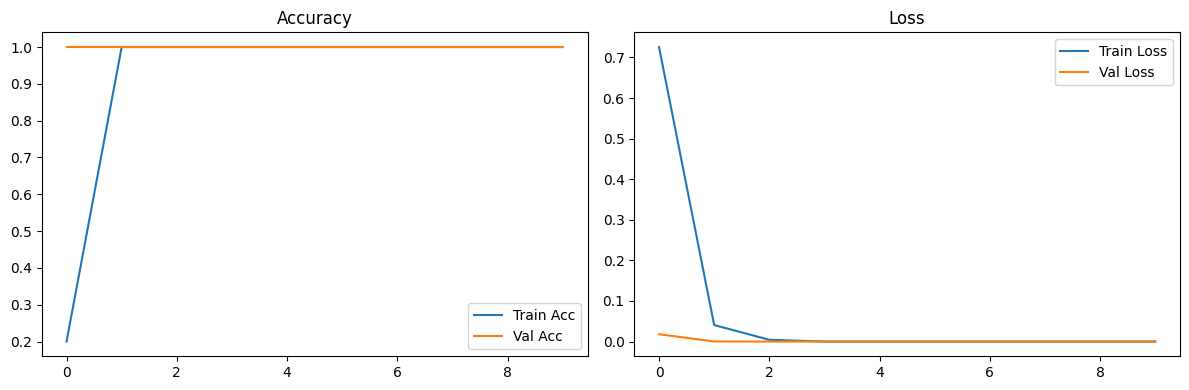

✅ Model saved as wavelet_cnn_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step

❌ Misclassified images:


In [14]:
# WaveletCNN.ipynb
# This notebook builds a CNN to classify spectrograms as storm/non-storm

import os
import numpy as np
import shutil
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import random

# Parameters
image_dir = r"G:\Το Drive μου\PhD\PhdRelated\ML\WaveletAnalysis\daily_spectrograms"
label_dir = r"G:\Το Drive μου\PhD\PhdRelated\ML\WaveletAnalysis\labels"
storm_dir = os.path.join(image_dir, "storm")
quiet_dir = os.path.join(image_dir, "quiet")
img_height, img_width = 256, 256
batch_size = 16
epochs = 10

# Utility function to copy images by SYM-H threshold
def copy_spectrograms_by_symh(symh_file, image_dir, target_dir, threshold, direction="<", limit=None):
    df = pd.read_csv(symh_file, delim_whitespace=True, skiprows=17, header=None)
    df.columns = ["Date", "Time", "DOY", "ASY-D", "ASY-H", "SYM-D", "SYM-H"]
    df["Date"] = pd.to_datetime(df["Date"]).dt.date

    daily_min = df.groupby("Date")["SYM-H"].min()

    if direction == "<":
        selected_days = daily_min[daily_min < threshold].index
    elif direction == ">":
        selected_days = daily_min[daily_min > threshold].index
    else:
        raise ValueError("direction must be '<' or '>'")

    if limit:
        selected_days = selected_days[:limit]

    os.makedirs(target_dir, exist_ok=True)
    copied = 0
    for d in selected_days:
        fname = f"spectrogram_{d}.png"
        src = os.path.join(image_dir, fname)
        dst = os.path.join(target_dir, fname)
        if os.path.exists(src):
            shutil.copy(src, dst)
            copied += 1

    print(f"✅ Copied {copied} spectrograms to {target_dir}")

# Call the function for storm and quiet spectrograms
symh_data_file = r"G:\Το Drive μου\PhD\PhdRelated\ML\WaveletAnalysis\KyotoSymhYear2015.dat"

# Clear existing folders
shutil.rmtree(storm_dir, ignore_errors=True)
os.makedirs(storm_dir, exist_ok=True)
shutil.rmtree(quiet_dir, ignore_errors=True)
os.makedirs(quiet_dir, exist_ok=True)

# Copy storm and quiet samples (limited to same count for balance)
copy_spectrograms_by_symh(symh_data_file, image_dir, storm_dir, threshold=-100, direction="<", limit=12)
copy_spectrograms_by_symh(symh_data_file, image_dir, quiet_dir, threshold=-20, direction=">", limit=12)

# 3. Load images
balanced_dir = image_dir

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    balanced_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    balanced_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

# 4. Define CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 🚫 Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# 5. Train
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=[early_stopping]
)

# 6. Plot results
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.legend()
plt.tight_layout()
plt.show()

# 7. Save model
model.save("wavelet_cnn_model.h5")
print("✅ Model saved as wavelet_cnn_model.h5")

# 8. Evaluate on validation set
val_generator.reset()
preds = model.predict(val_generator, verbose=1)
predicted_labels = (preds > 0.5).astype(int).flatten()
true_labels = val_generator.classes
filenames = val_generator.filenames

misclassified_indices = np.where(predicted_labels != true_labels)[0]
print("\n❌ Misclassified images:")
for i in misclassified_indices:
    print(f"{filenames[i]} - True: {true_labels[i]} Predicted: {predicted_labels[i]}")


C:\Users\User\AppData\Local\Temp\ipykernel_6684\240491356.py:27: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(symh_file, delim_whitespace=True, skiprows=17, header=None)


✅ Copied 8 spectrograms to G:\Το Drive μου\PhD\PhdRelated\ML\WaveletAnalysis\daily_spectrograms\storm


C:\Users\User\AppData\Local\Temp\ipykernel_6684\240491356.py:27: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(symh_file, delim_whitespace=True, skiprows=17, header=None)


✅ Copied 7 spectrograms to G:\Το Drive μου\PhD\PhdRelated\ML\WaveletAnalysis\daily_spectrograms\quiet
Found 13 images belonging to 2 classes.
Found 2 images belonging to 2 classes.


C:\Users\User\miniconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\User\miniconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.3846 - loss: 0.6879 - val_accuracy: 0.5000 - val_loss: 0.7516
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 944ms/step - accuracy: 0.4615 - loss: 0.9026 - val_accuracy: 0.5000 - val_loss: 0.8016
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 993ms/step - accuracy: 0.7692 - loss: 0.5956 - val_accuracy: 0.5000 - val_loss: 0.8523
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6154 - loss: 0.6791 - val_accuracy: 0.0000e+00 - val_loss: 0.8217


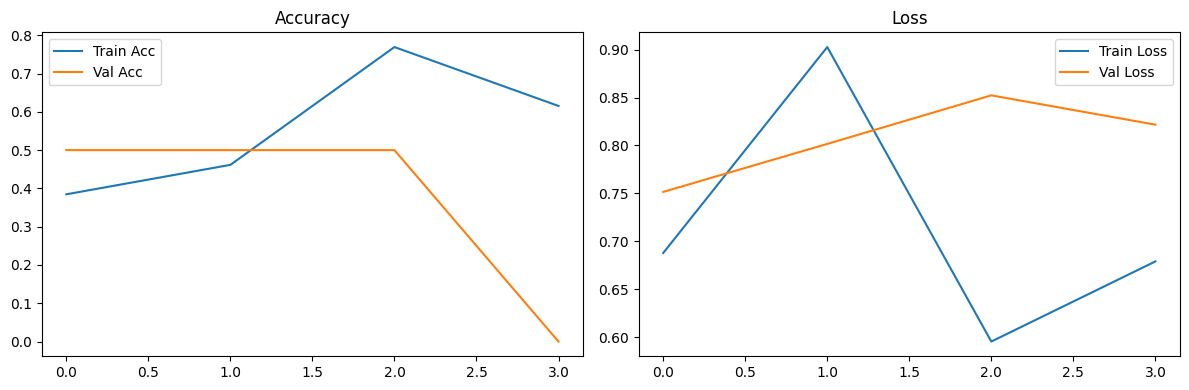

✅ Model saved as wavelet_cnn_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step

❌ Misclassified images:
quiet\spectrogram_2015-01-01.png - True: 0 Predicted: 1


In [15]:
# WaveletCNN.ipynb
# This notebook builds a CNN to classify spectrograms as storm/non-storm

import os
import numpy as np
import shutil
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import random

# Parameters
image_dir = r"G:\Το Drive μου\PhD\PhdRelated\ML\WaveletAnalysis\daily_spectrograms"
label_dir = r"G:\Το Drive μου\PhD\PhdRelated\ML\WaveletAnalysis\labels"
storm_dir = os.path.join(image_dir, "storm")
quiet_dir = os.path.join(image_dir, "quiet")
img_height, img_width = 256, 256
batch_size = 16
epochs = 10

# Utility function to copy images by SYM-H threshold
def copy_spectrograms_by_symh(symh_file, image_dir, target_dir, threshold, direction="<", limit=None):
    df = pd.read_csv(symh_file, delim_whitespace=True, skiprows=17, header=None)
    df.columns = ["Date", "Time", "DOY", "ASY-D", "ASY-H", "SYM-D", "SYM-H"]
    df["Date"] = pd.to_datetime(df["Date"]).dt.date

    daily_min = df.groupby("Date")["SYM-H"].min()

    if direction == "<":
        selected_days = daily_min[daily_min < threshold].index
    elif direction == ">":
        selected_days = daily_min[daily_min > threshold].index
    else:
        raise ValueError("direction must be '<' or '>'")

    if limit:
        selected_days = selected_days[:limit]

    os.makedirs(target_dir, exist_ok=True)
    copied = 0
    for d in selected_days:
        fname = f"spectrogram_{d}.png"
        src = os.path.join(image_dir, fname)
        dst = os.path.join(target_dir, fname)
        if os.path.exists(src):
            shutil.copy(src, dst)
            copied += 1

    print(f"✅ Copied {copied} spectrograms to {target_dir}")

# Call the function for storm and quiet spectrograms
symh_data_file = r"G:\Το Drive μου\PhD\PhdRelated\ML\WaveletAnalysis\KyotoSymhYear2015.dat"

# Clear existing folders
shutil.rmtree(storm_dir, ignore_errors=True)
os.makedirs(storm_dir, exist_ok=True)
shutil.rmtree(quiet_dir, ignore_errors=True)
os.makedirs(quiet_dir, exist_ok=True)

# Copy storm and quiet samples (limited to same count for balance)
copy_spectrograms_by_symh(symh_data_file, image_dir, storm_dir, threshold=-90, direction="<", limit=12)
copy_spectrograms_by_symh(symh_data_file, image_dir, quiet_dir, threshold=-30, direction=">", limit=12)

# 3. Load images
balanced_dir = image_dir

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    balanced_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    balanced_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

# 4. Define CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 🚫 Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# 5. Train
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=[early_stopping]
)

# 6. Plot results
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.legend()
plt.tight_layout()
plt.show()

# 7. Save model
model.save("wavelet_cnn_model.h5")
print("✅ Model saved as wavelet_cnn_model.h5")

# 8. Evaluate on validation set
val_generator.reset()
preds = model.predict(val_generator, verbose=1)
predicted_labels = (preds > 0.5).astype(int).flatten()
true_labels = val_generator.classes
filenames = val_generator.filenames

misclassified_indices = np.where(predicted_labels != true_labels)[0]
print("\n❌ Misclassified images:")
for i in misclassified_indices:
    print(f"{filenames[i]} - True: {true_labels[i]} Predicted: {predicted_labels[i]}")


In [16]:
# train_model.py
# CNN to classify storm vs. quiet days based on wavelet spectrogram images

import os
import numpy as np
import pandas as pd
import shutil
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# --- CONFIGURATION ---
image_dir = "daily_spectrograms"
storm_dir = os.path.join(image_dir, "storm")
quiet_dir = os.path.join(image_dir, "quiet")
symh_file = "KyotoSymhYear2015.dat"

img_height, img_width = 256, 256
batch_size = 16
epochs = 10

# --- UTILITY: Copy images based on SYM-H threshold ---
def copy_spectrograms_by_symh(symh_file, image_dir, target_dir, threshold, direction="<", limit=None):
    df = pd.read_csv(symh_file, delim_whitespace=True, skiprows=17, header=None)
    df.columns = ["Date", "Time", "DOY", "ASY-D", "ASY-H", "SYM-D", "SYM-H"]
    df["Date"] = pd.to_datetime(df["Date"]).dt.date
    
    daily_min = df.groupby("Date")["SYM-H"].min()

    if direction == "<":
        selected_days = daily_min[daily_min < threshold].index
    else:
        selected_days = daily_min[daily_min > threshold].index

    if limit:
        selected_days = selected_days[:limit]

    os.makedirs(target_dir, exist_ok=True)
    copied = 0
    for d in selected_days:
        fname = f"spectrogram_{d}.png"
        src = os.path.join(image_dir, fname)
        dst = os.path.join(target_dir, fname)
        if os.path.exists(src):
            shutil.copy(src, dst)
            copied += 1

    print(f"✅ Copied {copied} spectrograms to {target_dir}")

# --- STEP 1: Prepare folders ---
shutil.rmtree(storm_dir, ignore_errors=True)
os.makedirs(storm_dir, exist_ok=True)
shutil.rmtree(quiet_dir, ignore_errors=True)
os.makedirs(quiet_dir, exist_ok=True)

copy_spectrograms_by_symh(symh_file, image_dir, storm_dir, threshold=-100, direction="<", limit=12)
copy_spectrograms_by_symh(symh_file, image_dir, quiet_dir, threshold=-20, direction=">", limit=12)

# --- STEP 2: Load Images ---
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    image_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    image_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

# --- STEP 3: Define CNN ---
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# --- STEP 4: Train ---
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=[early_stopping]
)

# --- STEP 5: Plot ---
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.legend()
plt.tight_layout()
plt.show()

# --- STEP 6: Save Model ---
model.save("wavelet_cnn_model.h5")
print("✅ Model saved as wavelet_cnn_model.h5")


C:\Users\User\AppData\Local\Temp\ipykernel_6684\1397629796.py:27: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(symh_file, delim_whitespace=True, skiprows=17, header=None)


✅ Copied 0 spectrograms to daily_spectrograms\storm


C:\Users\User\AppData\Local\Temp\ipykernel_6684\1397629796.py:27: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(symh_file, delim_whitespace=True, skiprows=17, header=None)


✅ Copied 0 spectrograms to daily_spectrograms\quiet
Found 0 images belonging to 2 classes.
Found 0 images belonging to 2 classes.


C:\Users\User\miniconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\User\miniconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


ValueError: The PyDataset has length 0

In [1]:
# train_model.py
# CNN to classify storm vs. quiet days based on wavelet spectrogram images

import os
import numpy as np
import pandas as pd
import shutil
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# --- CONFIGURATION ---
image_dir = "daily_spectrograms"
storm_dir = os.path.join(image_dir, "storm")
quiet_dir = os.path.join(image_dir, "quiet")
symh_file = "KyotoSymhYear2015.dat"

img_height, img_width = 256, 256
batch_size = 16
epochs = 10

# --- UTILITY: Copy images based on SYM-H threshold ---
def copy_spectrograms_by_symh(symh_file, image_dir, target_dir, threshold, direction="<", limit=None):
    df = pd.read_csv(symh_file, delim_whitespace=True, skiprows=17, header=None)
    df.columns = ["Date", "Time", "DOY", "ASY-D", "ASY-H", "SYM-D", "SYM-H"]
    df["Date"] = pd.to_datetime(df["Date"]).dt.date
    
    daily_min = df.groupby("Date")["SYM-H"].min()

    if direction == "<":
        selected_days = daily_min[daily_min < threshold].index
    else:
        selected_days = daily_min[daily_min > threshold].index

    if limit:
        selected_days = selected_days[:limit]

    os.makedirs(target_dir, exist_ok=True)
    copied = 0
    for d in selected_days:
        fname = f"spectrogram_{d}.png"
        src = os.path.join(image_dir, fname)
        dst = os.path.join(target_dir, fname)
        if os.path.exists(src):
            shutil.copy(src, dst)
            copied += 1

    print(f"✅ Copied {copied} spectrograms to {target_dir}")

# --- STEP 1: Prepare folders ---
shutil.rmtree(storm_dir, ignore_errors=True)
os.makedirs(storm_dir, exist_ok=True)
shutil.rmtree(quiet_dir, ignore_errors=True)
os.makedirs(quiet_dir, exist_ok=True)

copy_spectrograms_by_symh(symh_file, image_dir, storm_dir, threshold=-100, direction="<", limit=12)
copy_spectrograms_by_symh(symh_file, image_dir, quiet_dir, threshold=-20, direction=">", limit=12)

# --- STEP 2: Load Images ---
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    image_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    image_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

# --- STEP 3: Define CNN ---
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# --- STEP 4: Train ---
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=[early_stopping]
)

# --- STEP 5: Plot ---
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.legend()
plt.tight_layout()
plt.show()

# --- STEP 6: Save Model ---
model.save("wavelet_cnn_model.h5")
print("✅ Model saved as wavelet_cnn_model.h5")


C:\Users\User\AppData\Local\Temp\ipykernel_20712\1397629796.py:27: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(symh_file, delim_whitespace=True, skiprows=17, header=None)


✅ Copied 0 spectrograms to daily_spectrograms\storm


C:\Users\User\AppData\Local\Temp\ipykernel_20712\1397629796.py:27: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(symh_file, delim_whitespace=True, skiprows=17, header=None)


✅ Copied 0 spectrograms to daily_spectrograms\quiet
Found 0 images belonging to 2 classes.
Found 0 images belonging to 2 classes.


C:\Users\User\miniconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\User\miniconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


ValueError: The PyDataset has length 0

In [2]:
# train_model.py
# CNN to classify storm vs. quiet days based on wavelet spectrogram images

import os
import numpy as np
import pandas as pd
import shutil
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# --- CONFIGURATION ---
image_dir = "daily_spectrograms"
storm_dir = os.path.join(image_dir, "storm")
quiet_dir = os.path.join(image_dir, "quiet")
symh_file = "KyotoSymhYear2015.dat"

img_height, img_width = 256, 256
batch_size = 16
epochs = 10

# --- UTILITY: Copy images based on SYM-H threshold ---
def copy_spectrograms_by_symh(symh_file, image_dir, target_dir, threshold, direction="<", limit=None):
    df = pd.read_csv(symh_file, delim_whitespace=True, skiprows=17, header=None)
    df.columns = ["Date", "Time", "DOY", "ASY-D", "ASY-H", "SYM-D", "SYM-H"]
    df["Date"] = pd.to_datetime(df["Date"]).dt.date

    daily_min = df.groupby("Date")["SYM-H"].min()

    if direction == "<":
        selected_days = daily_min[daily_min < threshold].index
    else:
        selected_days = daily_min[daily_min > threshold].index

    if limit:
        selected_days = selected_days[:limit]

    os.makedirs(target_dir, exist_ok=True)
    copied = 0
    for d in selected_days:
        fname = f"spectrogram_{d}.png"

        # Recursively look for the file
        found_path = None
        for root, _, files in os.walk(image_dir):
            if fname in files:
                found_path = os.path.join(root, fname)
                break

        if found_path:
            dst = os.path.join(target_dir, fname)
            shutil.copy(found_path, dst)
            copied += 1
        else:
            print(f"⚠️ Missing file: {fname}")

    print(f"✅ Copied {copied} spectrograms to {target_dir}")

# --- STEP 1: Prepare folders ---
shutil.rmtree(storm_dir, ignore_errors=True)
os.makedirs(storm_dir, exist_ok=True)
shutil.rmtree(quiet_dir, ignore_errors=True)
os.makedirs(quiet_dir, exist_ok=True)

copy_spectrograms_by_symh(symh_file, image_dir, storm_dir, threshold=-100, direction="<", limit=12)
copy_spectrograms_by_symh(symh_file, image_dir, quiet_dir, threshold=-20, direction=">", limit=12)

# --- STEP 2: Load Images ---
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    image_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    image_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

# --- STEP 3: Define CNN ---
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# --- STEP 4: Train ---
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=[early_stopping]
)

# --- STEP 5: Plot ---
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.legend()
plt.tight_layout()
plt.show()

# --- STEP 6: Save Model ---
model.save("wavelet_cnn_model.h5")
print("✅ Model saved as wavelet_cnn_model.h5")


C:\Users\User\AppData\Local\Temp\ipykernel_20712\3048097610.py:27: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(symh_file, delim_whitespace=True, skiprows=17, header=None)


⚠️ Missing file: spectrogram_2015-01-07.png
⚠️ Missing file: spectrogram_2015-03-17.png
⚠️ Missing file: spectrogram_2015-03-18.png
⚠️ Missing file: spectrogram_2015-06-08.png
⚠️ Missing file: spectrogram_2015-06-22.png
⚠️ Missing file: spectrogram_2015-06-23.png
⚠️ Missing file: spectrogram_2015-08-27.png
⚠️ Missing file: spectrogram_2015-09-09.png
⚠️ Missing file: spectrogram_2015-10-07.png
⚠️ Missing file: spectrogram_2015-11-07.png
⚠️ Missing file: spectrogram_2015-12-20.png
⚠️ Missing file: spectrogram_2015-12-21.png
✅ Copied 0 spectrograms to daily_spectrograms\storm


C:\Users\User\AppData\Local\Temp\ipykernel_20712\3048097610.py:27: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(symh_file, delim_whitespace=True, skiprows=17, header=None)


⚠️ Missing file: spectrogram_2015-01-18.png
⚠️ Missing file: spectrogram_2015-01-19.png
⚠️ Missing file: spectrogram_2015-01-20.png
⚠️ Missing file: spectrogram_2015-01-21.png
⚠️ Missing file: spectrogram_2015-01-25.png
⚠️ Missing file: spectrogram_2015-02-04.png
⚠️ Missing file: spectrogram_2015-02-06.png
⚠️ Missing file: spectrogram_2015-02-09.png
⚠️ Missing file: spectrogram_2015-02-10.png
⚠️ Missing file: spectrogram_2015-02-11.png
⚠️ Missing file: spectrogram_2015-02-12.png
⚠️ Missing file: spectrogram_2015-02-13.png
✅ Copied 0 spectrograms to daily_spectrograms\quiet
Found 0 images belonging to 2 classes.
Found 0 images belonging to 2 classes.


C:\Users\User\miniconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\User\miniconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


ValueError: The PyDataset has length 0

In [3]:
import os

image_dir = "daily_spectrograms"
all_files = []

# List all .png files in the directory (including subfolders)
for root, _, files in os.walk(image_dir):
    for f in files:
        if f.endswith(".png"):
            all_files.append(f)

# Show the first few filenames
print("🔍 Found", len(all_files), "PNG files. First few:")
print(all_files[:10])


🔍 Found 0 PNG files. First few:
[]


In [4]:
# train_model.py
# CNN to classify storm vs. quiet days based on wavelet spectrogram images

import os
import numpy as np
import pandas as pd
import shutil
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# --- CONFIGURATION ---
image_dir = r"G:\Το Drive μου\PhD\PhdRelated\ML\WaveletAnalysis\daily_spectrograms"
storm_dir = os.path.join(image_dir, "storm")
quiet_dir = os.path.join(image_dir, "quiet")
symh_file = "KyotoSymhYear2015.dat"

img_height, img_width = 256, 256
batch_size = 16
epochs = 10

# --- UTILITY: Copy images based on SYM-H threshold ---
def copy_spectrograms_by_symh(symh_file, image_dir, target_dir, threshold, direction="<", limit=None):
    df = pd.read_csv(symh_file, delim_whitespace=True, skiprows=17, header=None)
    df.columns = ["Date", "Time", "DOY", "ASY-D", "ASY-H", "SYM-D", "SYM-H"]
    df["Date"] = pd.to_datetime(df["Date"]).dt.date

    daily_min = df.groupby("Date")["SYM-H"].min()

    if direction == "<":
        selected_days = daily_min[daily_min < threshold].index
    else:
        selected_days = daily_min[daily_min > threshold].index

    if limit:
        selected_days = selected_days[:limit]

    os.makedirs(target_dir, exist_ok=True)
    copied = 0
    for d in selected_days:
        fname = f"spectrogram_{d}.png"

        # Recursively look for the file
        found_path = None
        for root, _, files in os.walk(image_dir):
            if fname in files:
                found_path = os.path.join(root, fname)
                break

        if found_path:
            dst = os.path.join(target_dir, fname)
            shutil.copy(found_path, dst)
            copied += 1
        else:
            print(f"⚠️ Missing file: {fname}")

    print(f"✅ Copied {copied} spectrograms to {target_dir}")

# --- STEP 1: Prepare folders ---
shutil.rmtree(storm_dir, ignore_errors=True)
os.makedirs(storm_dir, exist_ok=True)
shutil.rmtree(quiet_dir, ignore_errors=True)
os.makedirs(quiet_dir, exist_ok=True)

copy_spectrograms_by_symh(symh_file, image_dir, storm_dir, threshold=-100, direction="<", limit=12)
copy_spectrograms_by_symh(symh_file, image_dir, quiet_dir, threshold=-20, direction=">", limit=12)

# --- STEP 2: Load Images ---
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    image_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    image_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

# --- STEP 3: Define CNN ---
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# --- STEP 4: Train ---
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=[early_stopping]
)

# --- STEP 5: Plot ---
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.legend()
plt.tight_layout()
plt.show()

# --- STEP 6: Save Model ---
model.save("wavelet_cnn_model.h5")
print("✅ Model saved as wavelet_cnn_model.h5")


FileExistsError: [WinError 183] Δεν είναι δυνατή η δημιουργία ενός αρχείου όταν αυτό το αρχείο υπάρχει ήδη: 'G:\\Το Drive μου\\PhD\\PhdRelated\\ML\\WaveletAnalysis\\daily_spectrograms\\storm'

<>:27: SyntaxWarning: invalid escape sequence '\s'
<>:27: SyntaxWarning: invalid escape sequence '\s'
C:\Users\User\AppData\Local\Temp\ipykernel_20712\4139777329.py:27: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(symh_file, sep='\s+', skiprows=17, header=None)


⚠️ Missing file: spectrogram_2015-01-07.png
⚠️ Missing file: spectrogram_2015-03-17.png
⚠️ Missing file: spectrogram_2015-03-18.png
⚠️ Missing file: spectrogram_2015-06-23.png
⚠️ Missing file: spectrogram_2015-12-20.png
⚠️ Missing file: spectrogram_2015-12-21.png
✅ Copied 6 spectrograms to G:\Το Drive μου\PhD\PhdRelated\ML\WaveletAnalysis\daily_spectrograms\storm
⚠️ Missing file: spectrogram_2015-01-18.png
⚠️ Missing file: spectrogram_2015-01-19.png
⚠️ Missing file: spectrogram_2015-01-20.png
⚠️ Missing file: spectrogram_2015-01-21.png
⚠️ Missing file: spectrogram_2015-01-25.png
⚠️ Missing file: spectrogram_2015-02-04.png
⚠️ Missing file: spectrogram_2015-02-06.png
⚠️ Missing file: spectrogram_2015-02-09.png
⚠️ Missing file: spectrogram_2015-02-10.png
⚠️ Missing file: spectrogram_2015-02-11.png
⚠️ Missing file: spectrogram_2015-02-12.png
⚠️ Missing file: spectrogram_2015-02-13.png
✅ Copied 0 spectrograms to G:\Το Drive μου\PhD\PhdRelated\ML\WaveletAnalysis\daily_spectrograms\quiet
Foun

C:\Users\User\miniconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\User\miniconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.6000 - loss: 0.6834 - val_accuracy: 1.0000 - val_loss: 0.0043
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step - accuracy: 1.0000 - loss: 0.0158 - val_accuracy: 1.0000 - val_loss: 1.4217e-05
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step - accuracy: 1.0000 - loss: 9.9893e-05 - val_accuracy: 1.0000 - val_loss: 5.0103e-08
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step - accuracy: 1.0000 - loss: 4.0998e-05 - val_accuracy: 1.0000 - val_loss: 2.0050e-10
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step - accuracy: 1.0000 - loss: 3.0614e-08 - val_accuracy: 1.0000 - val_loss: 9.5520e-13
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step - accuracy: 1.0000 - loss: 1.1785e-10 - val_accuracy: 1.0000 - val_loss: 5.5540e-15
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step - accuracy: 1.0000 - loss: 7.7140e-09 - val_accuracy: 1.0000 - val_loss: 4.0304e-17
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step - accuracy: 1.0000 - loss: 

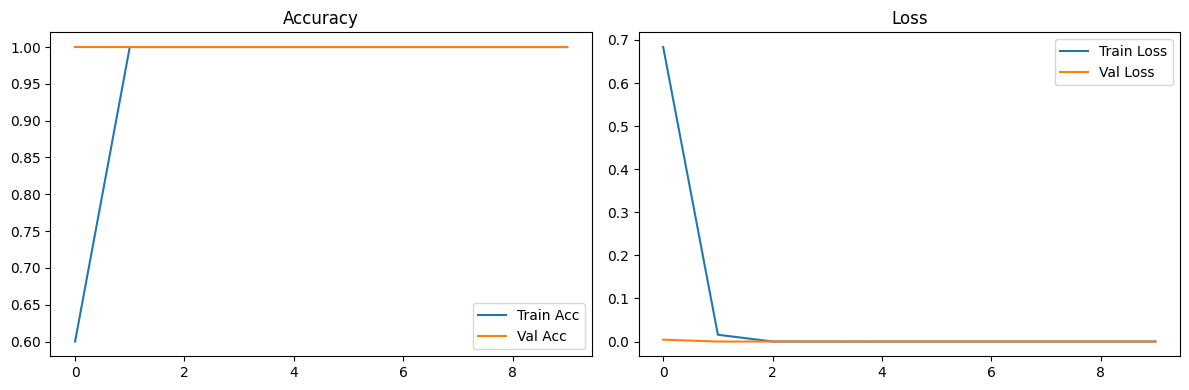

✅ Model saved as wavelet_cnn_model.h5


In [5]:
# train_model.py
# CNN to classify storm vs. quiet days based on wavelet spectrogram images

import os
import numpy as np
import pandas as pd
import shutil
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# --- CONFIGURATION ---
image_dir = r"G:\Το Drive μου\PhD\PhdRelated\ML\WaveletAnalysis\daily_spectrograms"
storm_dir = os.path.join(image_dir, "storm")
quiet_dir = os.path.join(image_dir, "quiet")
symh_file = "KyotoSymhYear2015.dat"

img_height, img_width = 256, 256
batch_size = 16
epochs = 10

# --- UTILITY: Copy images based on SYM-H threshold ---
def copy_spectrograms_by_symh(symh_file, image_dir, target_dir, threshold, direction="<", limit=None):
    df = pd.read_csv(symh_file, sep='\s+', skiprows=17, header=None)
    df.columns = ["Date", "Time", "DOY", "ASY-D", "ASY-H", "SYM-D", "SYM-H"]
    df["Date"] = pd.to_datetime(df["Date"]).dt.date

    daily_min = df.groupby("Date")["SYM-H"].min()

    if direction == "<":
        selected_days = daily_min[daily_min < threshold].index
    else:
        selected_days = daily_min[daily_min > threshold].index

    if limit:
        selected_days = selected_days[:limit]

    os.makedirs(target_dir, exist_ok=True)
    copied = 0
    for d in selected_days:
        fname = f"spectrogram_{d}.png"

        # Recursively look for the file
        found_path = None
        for root, _, files in os.walk(image_dir):
            if fname in files:
                found_path = os.path.join(root, fname)
                break

        if found_path:
            dst = os.path.join(target_dir, fname)
            try:
                shutil.copy(found_path, dst)
                copied += 1
            except Exception as e:
                print(f"⚠️ Could not copy {fname}: {e}")
        else:
            print(f"⚠️ Missing file: {fname}")

    print(f"✅ Copied {copied} spectrograms to {target_dir}")

# --- STEP 1: Prepare folders ---
shutil.rmtree(storm_dir, ignore_errors=True)
shutil.rmtree(quiet_dir, ignore_errors=True)
os.makedirs(storm_dir, exist_ok=True)
os.makedirs(quiet_dir, exist_ok=True)

copy_spectrograms_by_symh(symh_file, image_dir, storm_dir, threshold=-100, direction="<", limit=12)
copy_spectrograms_by_symh(symh_file, image_dir, quiet_dir, threshold=-20, direction=">", limit=12)

# --- STEP 2: Load Images ---
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    image_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    image_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

# --- STEP 3: Define CNN ---
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# --- STEP 4: Train ---
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=[early_stopping]
)

# --- STEP 5: Plot ---
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.legend()
plt.tight_layout()
plt.show()

# --- STEP 6: Save Model ---
model.save("wavelet_cnn_model.h5")
print("✅ Model saved as wavelet_cnn_model.h5")
